In [1]:
import pymc as pm
import numpy as np
import arviz as az

In [2]:
corr = np.asarray([[1., .65], [.65, 1]])
std = np.asarray([1., 5.])
cov = corr * np.outer(std, std)
chol_cov = np.linalg.cholesky(cov)

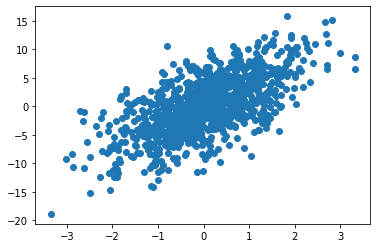

In [3]:
import matplotlib.pyplot as plt
x = np.random.randn(1000, 2) @ chol_cov.T
plt.plot(x[:, 0], x[:, 1], 'o');

In [4]:
# Set up model
with pm.Model() as m:
    x = pm.MvNormal('x', mu=np.asarray([10., 0.]), chol=chol_cov, lower=True)
    y = pm.HalfNormal('y', 1.)

# Initial sample
with m:
    trace = pm.sample(return_inferencedata=False, compute_convergence_checks=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [5]:
from pymc.step_methods.hmc import quadpotential

def fix_step_from_trace(trace, model):
    cov_est = pm.trace_cov(trace, vars=model.value_vars, model=model)
    potential = quadpotential.QuadPotentialFull(cov_est)
    # Use the largest step_size from previous tuning, 
    # alternatively we can compute the mean here
    step_size = np.max(trace.get_sampler_stats('step_size'))
    step_scale = step_size * (cov_est.shape[0] ** 0.25)
    step = pm.NUTS(vars=model.value_vars,
                   model=model,
                   potential=potential,
                   step_scale=step_scale,
                   adapt_step_size=False)
    step.tune = False
    return step

tuned_step = fix_step_from_trace(trace, m)

In [6]:
# New sample without tuning
with m:
    trace_new = pm.sample(initvals=trace[-1],
                          tune=0,
                          step=tuned_step, 
                          return_inferencedata=False,
                          compute_convergence_checks=False)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, y]


Sampling 4 chains for 0 tune and 1_000 draw iterations (0 + 4_000 draws total) took 17 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


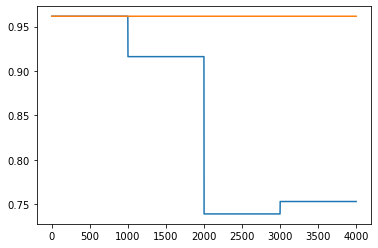

In [7]:
plt.plot(trace.get_sampler_stats('step_size'))
plt.plot(trace_new.get_sampler_stats('step_size'))

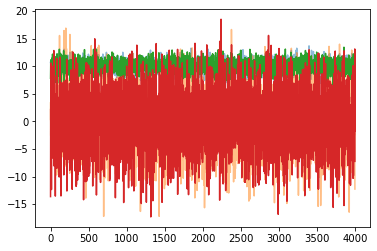

In [8]:
plt.plot(trace['x'], alpha=.5);
plt.plot(trace_new['x']);

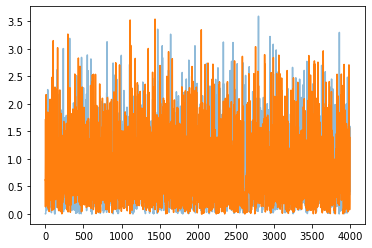

In [9]:
plt.plot(trace['y'], alpha=.5);
plt.plot(trace_new['y']);